In [1]:
import scanpy as sc, pandas as pd, numpy as np
import anndata, scvi

/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [33]:
! ls ~/oak/data/yimiao/yimiao-cellranger/pool4_2

_cmdline     _invocation  _mrosource  _perf._truncated_  _sitecheck  _uuid
_filelist    _jobmode	  outs	      pool4_2.mri.tgz	 _tags	     _vdrkill
_finalstate  _log	  _perf       SC_MULTI_CS	 _timestamp  _versions


In [34]:
fp4_2 = ! ls /home/users/chensj16/oak/data/yimiao/yimiao-cellranger/pool4_2/outs/per_sample_outs/**/count/sample_filtered_feature_bc_matrix.h5
fp_list = fp4_2 

In [35]:
import os
pool_info   = [os.path.dirname(fp).split('/')[7] for fp in fp_list]
sample_info = [os.path.dirname(fp).split('/')[-2] for fp in fp_list]

for i in range(len(pool_info)):
    print(f"{i},\t {pool_info[i]},\t {sample_info[i]}")

0,	 yimiao-cellranger,	 Ctrl_Ecto
1,	 yimiao-cellranger,	 Ctrl_Ecto-mTeSR
2,	 yimiao-cellranger,	 Ctrl_hPSC
3,	 yimiao-cellranger,	 SMARCB1_Ecto
4,	 yimiao-cellranger,	 SMARCB1_Ecto-mTeSR
5,	 yimiao-cellranger,	 SMARCB1_hPSC


In [36]:
sample_info =[
    'Ctrl-E.p4',
    'Ctrl-ET.p4',
    'Ctrl-hPSC.p4',
    'SMARCB1-E',
    'SMARCB1-ET',
    'SMARCB1-hPSC',
]
background = [s.split('-')[0] for s in sample_info]

import re
treatment = [s.split('-')[1] for s in sample_info]
treatment = [re.sub(r'\.p\d+$', '', s) for s in treatment] # remove .p[digit] suffix
treatment = [re.sub(r'\.\d+$', '', s) for s in treatment]  # remove .[digit] suffix
ectoderm = [1, 1, 0, 1, 1, 0]
mTeSR    = [0, 1, 0, 0, 1, 0]

sample_meta = pd.DataFrame({'sample_info':sample_info, 'background':background,'treatment':treatment,'ectoderm':ectoderm,'mTeSR':mTeSR })
sample_meta

,sample_info,background,treatment,ectoderm,mTeSR
0,Ctrl-E.p4,Ctrl,E,1,0
1,Ctrl-ET.p4,Ctrl,ET,1,1
2,Ctrl-hPSC.p4,Ctrl,hPSC,0,0
3,SMARCB1-E,SMARCB1,E,1,0
4,SMARCB1-ET,SMARCB1,ET,1,1
5,SMARCB1-hPSC,SMARCB1,hPSC,0,0


In [37]:
adata_list = [sc.read_10x_h5(fp) for fp in fp_list]

for i in range(len(pool_info)):
    adata_list[i].obs['pool']   = pool_info[i]
    adata_list[i].obs['sample'] = sample_info[i]
    adata_list[i].obs['background'] = background[i]
    adata_list[i].obs['treatment']  = treatment[i]
    adata_list[i].obs['ectoderm']   = ectoderm[i]
    adata_list[i].obs['mTeSR']      = mTeSR[i]

/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py

In [38]:
for adata in adata_list:
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata.obs_names = adata.obs['pool']+"|"+adata.obs['sample']+"|"+adata.obs_names 
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-") # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # hemoglobin genes
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "hb"], inplace=True, log1p=True
    )
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=10)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

In [39]:
adata_merged = anndata.concat(adata_list,join='outer')
adata_merged.obs['batch'] = adata_merged.obs['pool']+'|'+adata_merged.obs['sample']
sc.pp.highly_variable_genes(adata_merged, n_top_genes=2000, batch_key="batch")

In [40]:
import requests
def get_cell_cycle_genes() -> list:
    # Canonical list of cell cycle genes
    url = "https://raw.githubusercontent.com/scverse/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
    cell_cycle_genes = requests.get(url).text.split("\n")[:-1]
    return cell_cycle_genes

cell_cycle_genes = get_cell_cycle_genes()
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata_merged, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

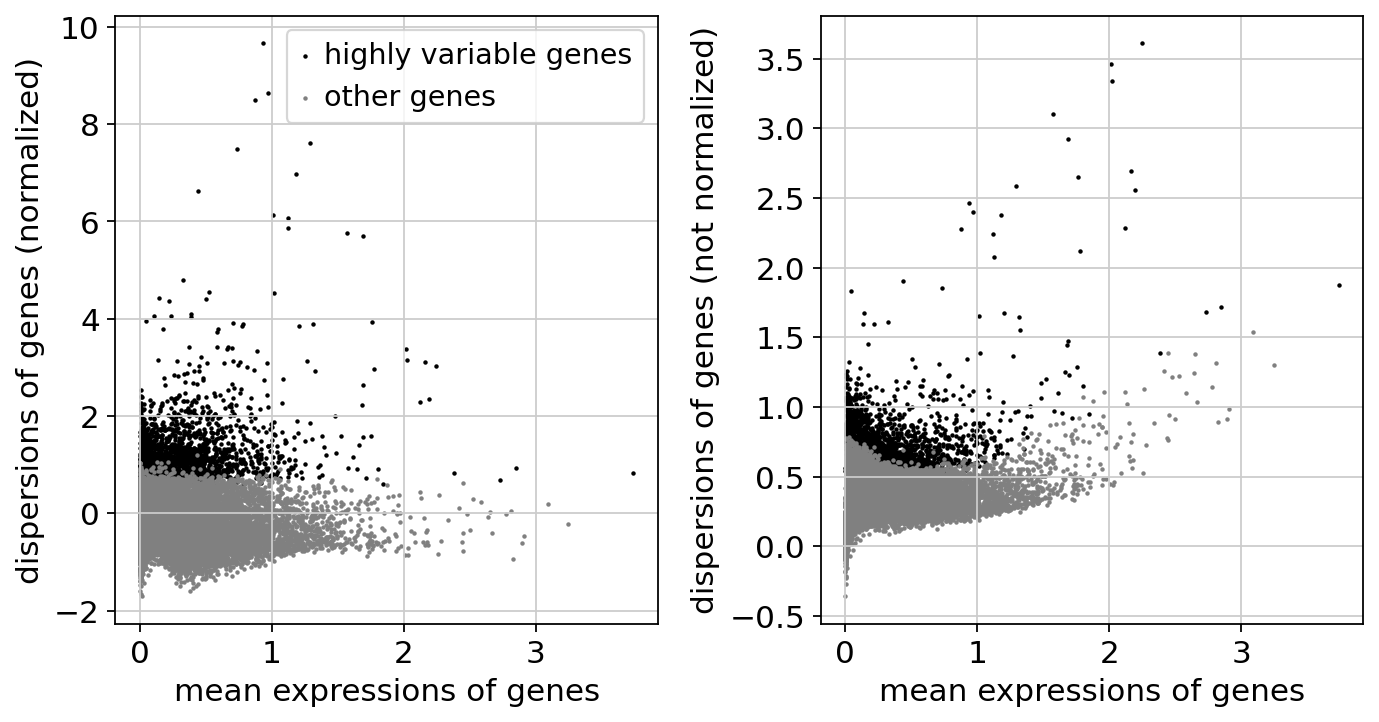

In [41]:
sc.set_figure_params(figsize=[5,5])
sc.pl.highly_variable_genes(adata_merged)

In [42]:
adata_merged

AnnData object with n_obs × n_vars = 30949 × 15037
    obs: 'pool', 'sample', 'background', 'treatment', 'ectoderm', 'mTeSR', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'batch', 'S_score', 'G2M_score', 'phase'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts'

In [43]:
adata_merged.obs['ann'] = adata_merged.obs['sample'].copy()
adata_merged.obs['ann'] = adata_merged.obs['ann'].replace(
{
    'Ctrl-E.p4'   : 'differentiated',
    'Ctrl-ET.p4'  : 'mal-reversed',
    'Ctrl-hPSC.p4': 'hPSC',
    'SMARCB1-E'   : 'differentiated',
    'SMARCB1-ET'  : 'reversed',
    'SMARCB1-hPSC': 'hPSC'
})

adata_merged.obs['pool'] = 'pool4_2'

/tmp/ipykernel_9965/2642175280.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_merged.obs['ann'] = adata_merged.obs['ann'].replace(


In [90]:
adata_merged.write_h5ad('./pool4_merged.250505.h5ad')

In [8]:
pool4_merged = sc.read_h5ad('./pool4_merged.250505.h5ad')


In [9]:
ref_merged = sc.read_h5ad('./adata_merged.250501.h5ad')


In [10]:
import anndata
adata_merged = anndata.concat([ref_merged, pool4_merged], join='outer')


# load scvi model

In [11]:
ref_merged

AnnData object with n_obs × n_vars = 123822 × 17960
    obs: 'pool', 'sample', 'background', 'treatment', 'ectoderm', 'mTeSR', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'batch', 'S_score', 'G2M_score', 'phase', 'ann', 'is_hPSC', '_scvi_batch', '_scvi_labels', 'leiden0.3', 'leiden0.5', 'leiden0.7', 'JUN', 'JUNB', 'JUND', 'FOS', 'FOSB', 'FOSL2', 'HSP90AA1', 'HSP90AB1', 'HSPA1A', 'HSPA1B', 'HSPA5', 'HSPA8', 'HSPB1', 'MT-ND1', 'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'SRY', 'KDM5D', 'DDX3Y', 'UTY', 'ZFY', 'KDM6A', 'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 

In [12]:
stress_genes = ["JUN","JUNB","JUND", "FOS","FOSB","FOSL2", "HSP90AA1","HSP90AB1","HSPA1A","HSPA1B","HSPA5","HSPA8","HSPB1"]
mt_genes = adata_merged.var[adata_merged.var.index.str.startswith('MT-')].index.tolist()
sex_genes = ['SRY','RPS4Y1','KDM5D','DDX3Y','UTY','ZFY',
             'XIST','TSIX','KDM6A', 'EIF2S3X']
cell_cycle_genes = [
    "MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG","GINS2","MCM6","CDCA7","DTL","PRIM1",
    "UHRF1","MLF1IP","HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7",
    "POLD3","MSH2","ATAD2","RAD51","RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM","CASP8AP2",
    "USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8","HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2",
    "TOP2A","NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF","TACC3","FAM64A","SMC4","CCNB2",
    "CKAP2L","CKAP2","AURKB","BUB1","KIF11","ANP32E","TUBB4B","GTSE1","KIF20B","HJURP","CDCA3",
    "HN1","CDC20","TTK","CDC25C","KIF2C","RANGAP1","NCAPD2","DLGAP5","CDCA2","CDCA8","ECT2","KIF23",
    "HMMR","AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF","NEK2","G2E3","GAS2L3","CBX5","CENPA"]

nuisance_genes = stress_genes + mt_genes + sex_genes + cell_cycle_genes
nuisance_genes = [g for g in nuisance_genes if g in adata_merged.var_names]

# put nuisances to .obs as a nuisance factor
for g in nuisance_genes:
    exp = np.array(adata_merged[:,g].X.todense()).reshape([-1])
    adata_merged.obs[g] = exp.copy()

# remove the nuisance genes from the anndata
gene_subset = [g for g in adata_merged.var_names if g not in nuisance_genes]
adata_merged = adata_merged[:,gene_subset].copy()

In [13]:
scvi.model.SCVI.setup_anndata(
    adata_merged, layer="counts",
    batch_key='pool',
    categorical_covariate_keys = ["background", "pool"],
    continuous_covariate_keys  = ["pct_counts_mt", "log1p_n_genes_by_counts", 'log1p_total_counts'] + nuisance_genes,
)


In [14]:
model = scvi.model.SCVI(adata_merged, n_hidden=128, n_latent=30, n_layers=2)

In [15]:
model.train(max_epochs=60)


/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /share/software/user/open/py-jupyterlab/4.3.2_py312 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /share/software/user/open/py-jupyterlab/4.3.2_py312 ...
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which 

Epoch 60/60: 100%|███████████████████████████████████████████████████| 60/60 [11:19<00:00,  9.98s/it, v_num=1, train_loss_step=8.7e+3, train_loss_epoch=8.23e+3]

`Trainer.fit` stopped: `max_epochs=60` reached.



poch 60/60: 100%|███████████████████████████████████████████████████| 60/60 [11:19<00:00, 11.33s/it, v_num=1, train_loss_step=8.7e+3, train_loss_epoch=8.23e+3]

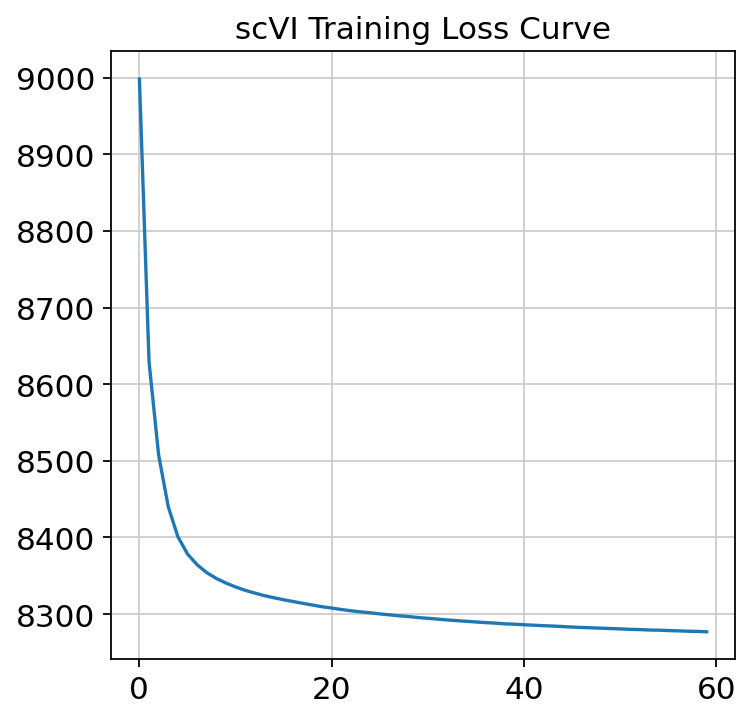

In [16]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[5,5])
plt.plot(model.history['elbo_train'], label='ELBO Train')
plt.title('scVI Training Loss Curve')
plt.show()

In [17]:
adata_merged.obsm['X_scvi'] = model.get_latent_representation()

In [18]:
import pymde
embedder = pymde.preserve_neighbors(adata_merged.obsm['X_scvi'], verbose=False, device='cuda', repulsive_fraction=0.5)
embedding = embedder.embed(verbose=False)
adata_merged.obsm['X_vimde'] =  embedding.detach().cpu().numpy()

/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/functions/losses.py:1: SyntaxWarning: invalid escape sequence '\d'
  """Losses: distortion functions derived from original deviations.
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/functions/losses.py:102: SyntaxWarning: invalid escape sequence '\e'
  """
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/functions/penalties.py:311: SyntaxWarning: invalid escape sequence '\l'
  """:math:`p(d) = \log(1 + d^{\\text{exponent}})`"""
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/functions/penalties.py:325: SyntaxWarning: invalid escape sequence '\l'
  """:math:`p(d) = \log(1 - \\exp(-d^\\text{exponent}))`"""
/scratch/users/chensj16/venvs/scvi/lib/python3.12/site-packages/pymde/quadratic.py:126: SyntaxWarning: invalid escape sequence '\q'
  """Compute a spectral embedding


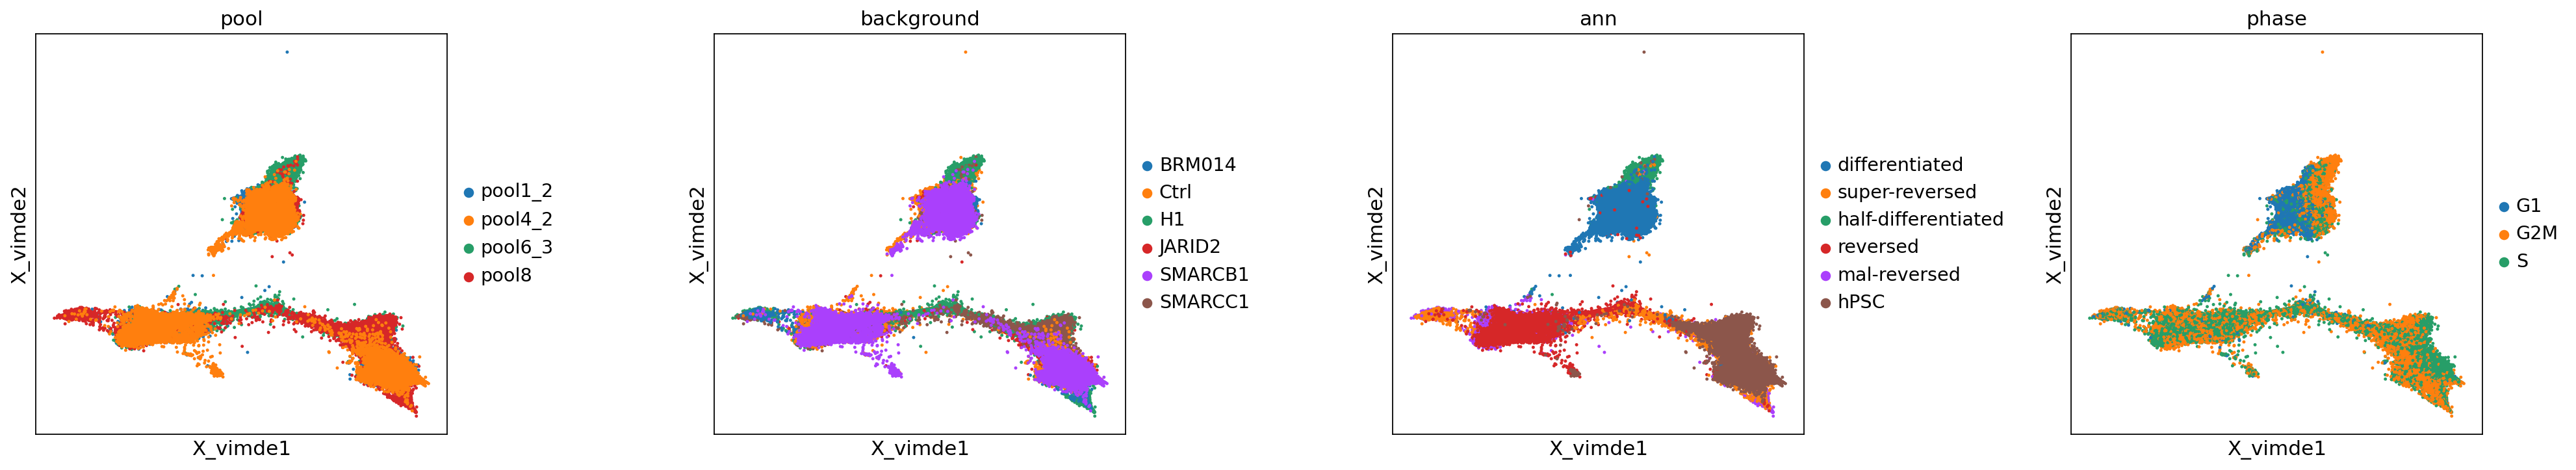

In [19]:
sc.pl.embedding(adata_merged, basis= 'X_vimde', wspace=0.5, color=['pool','background','ann','phase'],size=20)

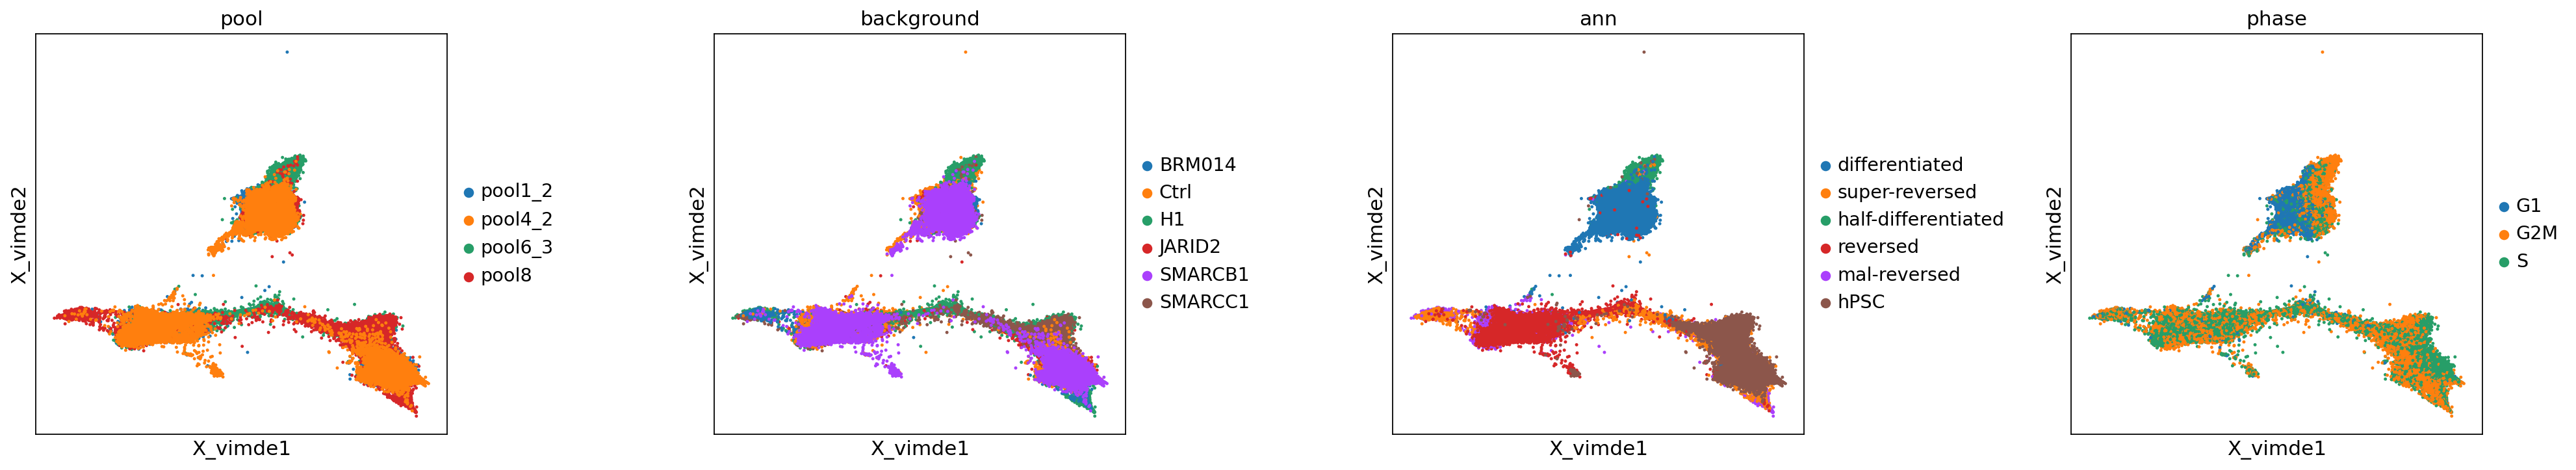

In [88]:
sc.pl.embedding(adata_merged, basis= 'X_vimde', wspace=0.5, color=['pool','background','ann','phase'],size=20)

In [21]:
adata_merged.write_h5ad('./adata_merged_pool1468.250505.h5ad')


In [22]:
canonical_merged = sc.read_h5ad('./adata_merged.250505-canonical.h5ad')

In [99]:
import pymde, torch

DEV = torch.device('cuda:0')

anchor_constraint = pymde.Anchored(
    anchors= torch.arange(canonical_merged.shape[0]).to(DEV),
    values= torch.from_numpy( canonical_merged.obsm['X_mde'] ).to(torch.float32).to(DEV)
)

In [43]:
canonical_merged.obsm['X_scvi']

(123822, 30)

In [118]:
pool4_merged = adata_merged[np.logical_and(adata_merged.obs['pool'] == 'pool4_2', adata_merged.obs['background']  =='SMARCB1')].copy()

In [119]:
pool4_merged.obsm['X_scvi'].shape

(18465, 30)

In [120]:
Z_cat = torch.from_numpy(np.concat([
        adata_merged[canonical_merged.obs_names, ].obsm['X_scvi'],
        pool4_merged.obsm['X_scvi']
    ], axis=0)).to(torch.float32).to(DEV)

In [121]:
cat_embedder = pymde.preserve_neighbors(Z_cat, constraint=anchor_constraint, init='random', device='cuda', verbose=False)

In [122]:
X_cat = cat_embedder.embed(verbose=False, max_iter=3000).detach().cpu().numpy()

In [124]:
X_pool4 = X_cat[canonical_merged.obsm['X_scvi'].shape[0]:, ]

In [125]:
pool4_merged.obsm['X_mde'] = X_pool4.copy()

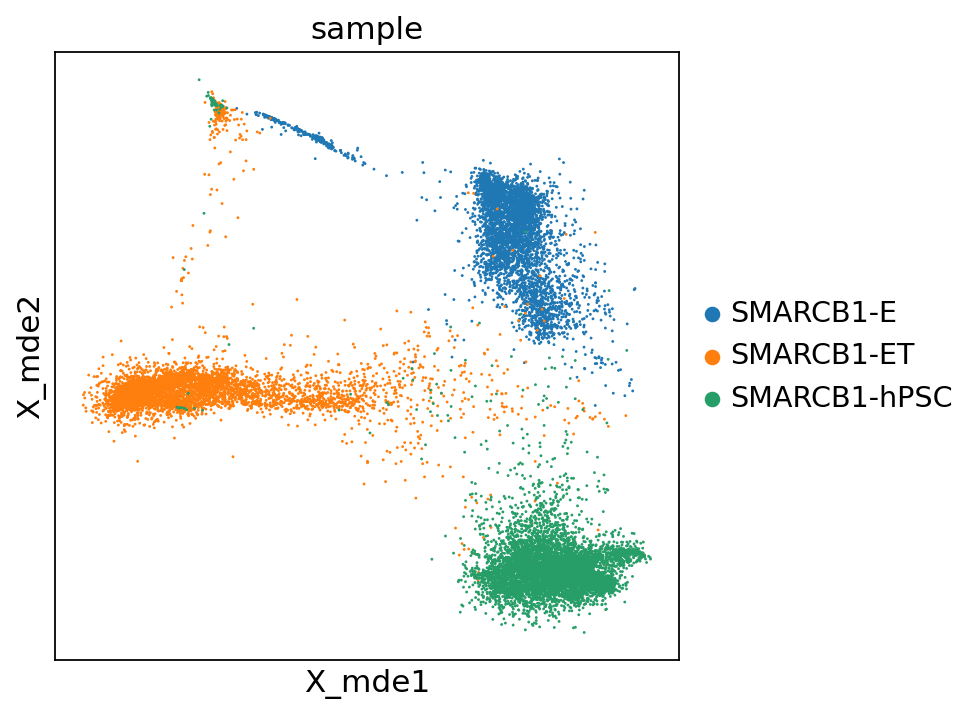

In [126]:
sc.pl.embedding(pool4_merged, basis='X_mde', color='sample')

In [127]:
sc.pp.neighbors(pool4_merged, use_rep='X_scvi')

In [130]:
sc.tl.leiden(pool4_merged, flavor="igraph" ,resolution=0.3, n_iterations=2)

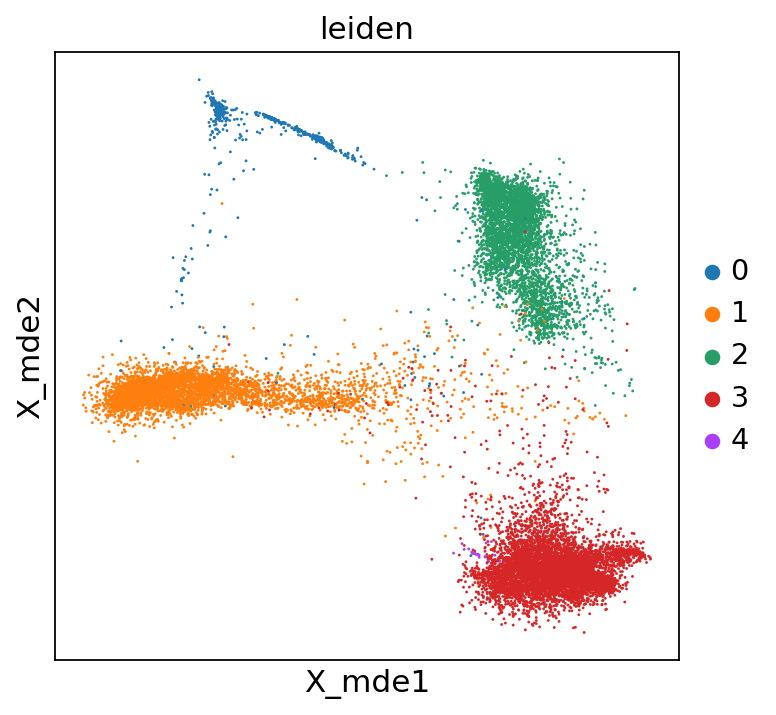

In [131]:
sc.pl.embedding(pool4_merged, basis='X_mde', color='leiden')

In [132]:
sc.tl.rank_genes_groups(pool4_merged, groupby='leiden')

In [138]:
sc.get.rank_genes_groups_df(pool4_merged, group='0').query("pvals_adj<0.05").head(50)

,names,scores,logfoldchanges,pvals,pvals_adj
0,PILRB,27.485126,2.030263,1.284068e-136,2.272105e-135
1,AASS,26.176664,1.392123,1.575055e-126,2.490139e-125
2,SYNGAP1,25.593075,1.996814,1.898548e-121,2.870195e-120
3,TAF1D,24.294352,1.468214,1.928181e-111,2.690764e-110
4,ANKRD10,24.190693,1.606280,1.231076e-110,1.700779e-109
5,CCNL2,23.973398,1.678806,6.913941e-109,9.407150e-108
6,ZNF519,23.138676,1.952773,1.977912e-102,2.542827e-101
7,OGT,19.497862,1.486067,3.442495e-76,3.336601e-75
8,RSRP1,19.374624,1.848729,2.794706e-75,2.689867e-74
9,C6orf141,18.515930,2.289717,1.930476e-69,1.745788e-68


In [142]:
pool4_merged =  pool4_merged[ pool4_merged .obs.leiden!='0' ] .copy()

In [160]:
pool4_merged.obs['sample']

yimiao-cellranger|SMARCB1-E|AAACAAGCATCATCACATACGTCA-1          SMARCB1-E
yimiao-cellranger|SMARCB1-E|AAACAAGCATTGCCGCATACGTCA-1          SMARCB1-E
yimiao-cellranger|SMARCB1-E|AAACCAATCGACTCACATACGTCA-1          SMARCB1-E
yimiao-cellranger|SMARCB1-E|AAACCAGGTACTTCAAATACGTCA-1          SMARCB1-E
yimiao-cellranger|SMARCB1-E|AAACCAGGTCCGGGTTATACGTCA-1          SMARCB1-E
                                                                 ...     
yimiao-cellranger|SMARCB1-hPSC|TTTGGCGGTTGCGGGAACTACTCA-1    SMARCB1-hPSC
yimiao-cellranger|SMARCB1-hPSC|TTTGTGAGTAACCTTAACTACTCA-1    SMARCB1-hPSC
yimiao-cellranger|SMARCB1-hPSC|TTTGTGAGTACAGCAAACTACTCA-1    SMARCB1-hPSC
yimiao-cellranger|SMARCB1-hPSC|TTTGTGAGTCCGGGTTACTACTCA-1    SMARCB1-hPSC
yimiao-cellranger|SMARCB1-hPSC|TTTGTGAGTCCTCCTGACTACTCA-1    SMARCB1-hPSC
Name: sample, Length: 16917, dtype: category
Categories (3, object): ['SMARCB1-E', 'SMARCB1-ET', 'SMARCB1-hPSC']

In [150]:
pool4_merged.uns['sample_colors'] = ['#4c704a', '#aac7e9', '#c78f39']

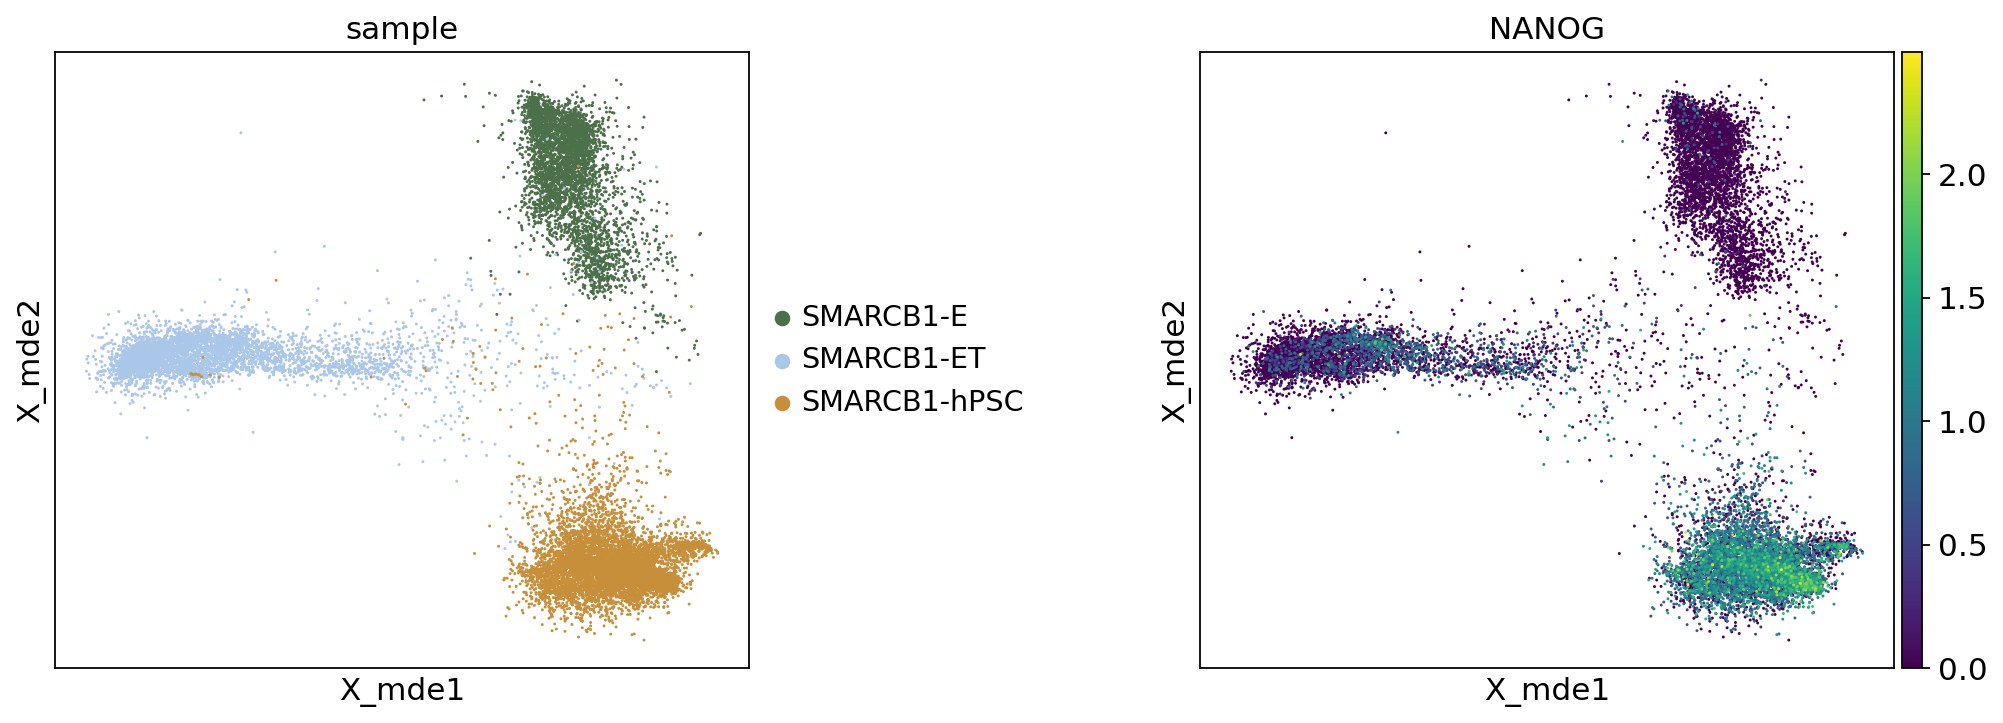

In [151]:
sc.pl.embedding(pool4_merged, basis='X_mde', color=['sample','NANOG'], wspace=0.5)

In [155]:
pool4_merged.write_h5ad('pool4_SMARCB1_merged.h5ad')

# Final Visualization

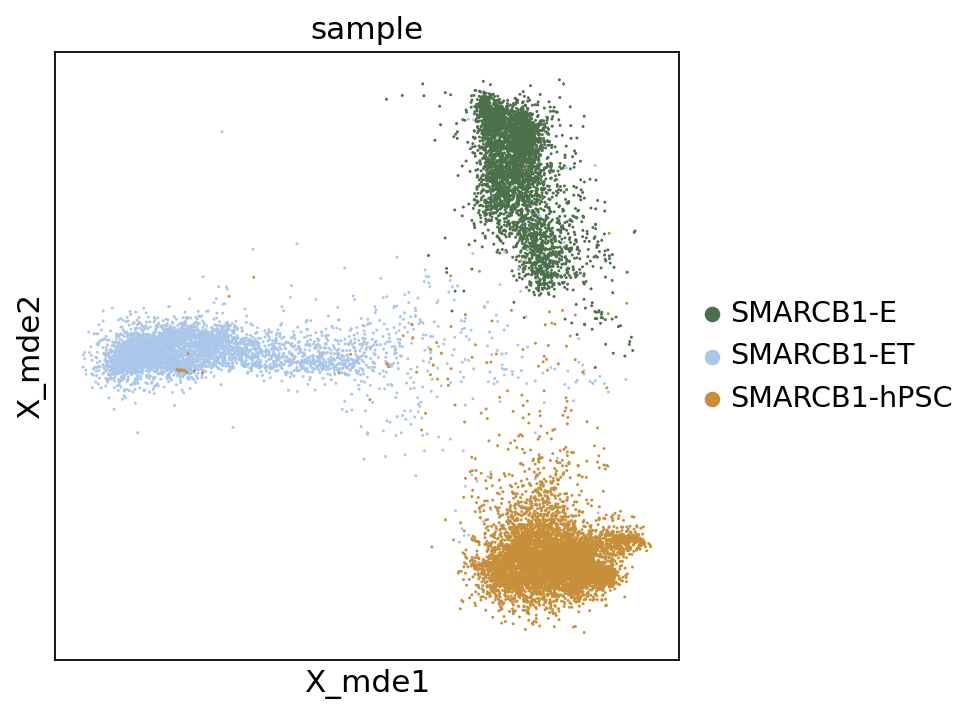

In [154]:
sc.pl.embedding(pool4_merged, basis='X_mde', color=['sample'], wspace=0.5)

In [165]:
order1 = ['SMARCB1-E', 'SMARCB1-ET','SMARCB1-hPSC' ]
color_lut =  {"SMARCB1-E":'#4c704a', 
              "SMARCB1-ET":'#aac7e9', 
              "SMARCB1-hPSC": '#c78f39'}

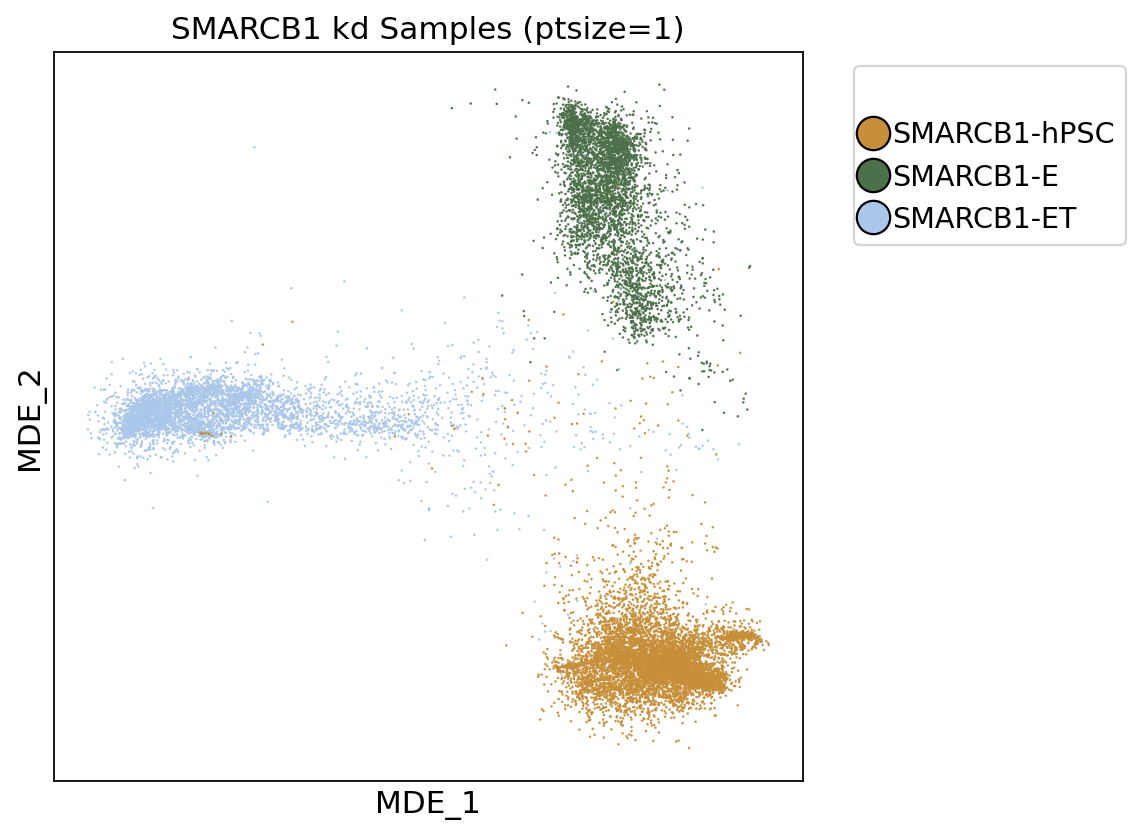

In [167]:
import seaborn as sns, matplotlib.pyplot as plt

adata1 = pool4_merged
order1 = ['SMARCB1-hPSC', 'SMARCB1-E', 'SMARCB1-ET' ]
data1 = pd.DataFrame(adata1.obsm['X_mde'], columns=['MDE_1','MDE_2'])
data1['Sample'] = adata1.obs['sample'].astype(str).tolist()

plt.figure(figsize=(6, 6))
scatter = sns.scatterplot(data=data1, x='MDE_1', y='MDE_2', hue='Sample', s=1, alpha=1, edgecolor=None,
                hue_order=order1,
                palette=color_lut)

# 手动创建 legend 句柄，alpha=1
from matplotlib.lines import Line2D
new_handles = [Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=color_lut[label],
                      markeredgecolor='black',
                      markersize=15, alpha=1.0)
               for label in order1]

plt.legend(handles=new_handles, labels=order1,
           title=' ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks([]);plt.yticks([]);plt.grid(False);
plt.title('SMARCB1 kd Samples (ptsize=1)')
plt.savefig("Figure.pool4-SMARCB1-samples.MDEmap.pdf", dpi=300, bbox_inches='tight')
plt.show()

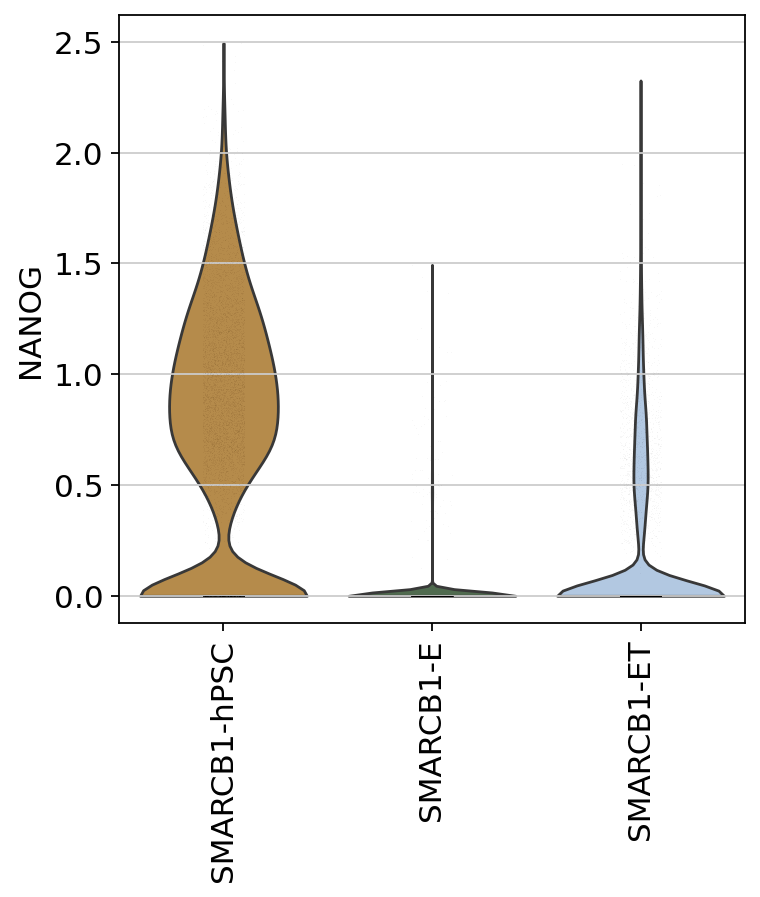

In [168]:
sc.settings.figdir = '.'
sc.pl.violin(adata1, groupby='sample', keys='NANOG', order=order1, rotation=90, size=0.07,density_norm='count',save='Figure.pool4-SMARCB1-samples.NANOG.violin.pdf')



/tmp/ipykernel_40906/2589077995.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.82, 1])


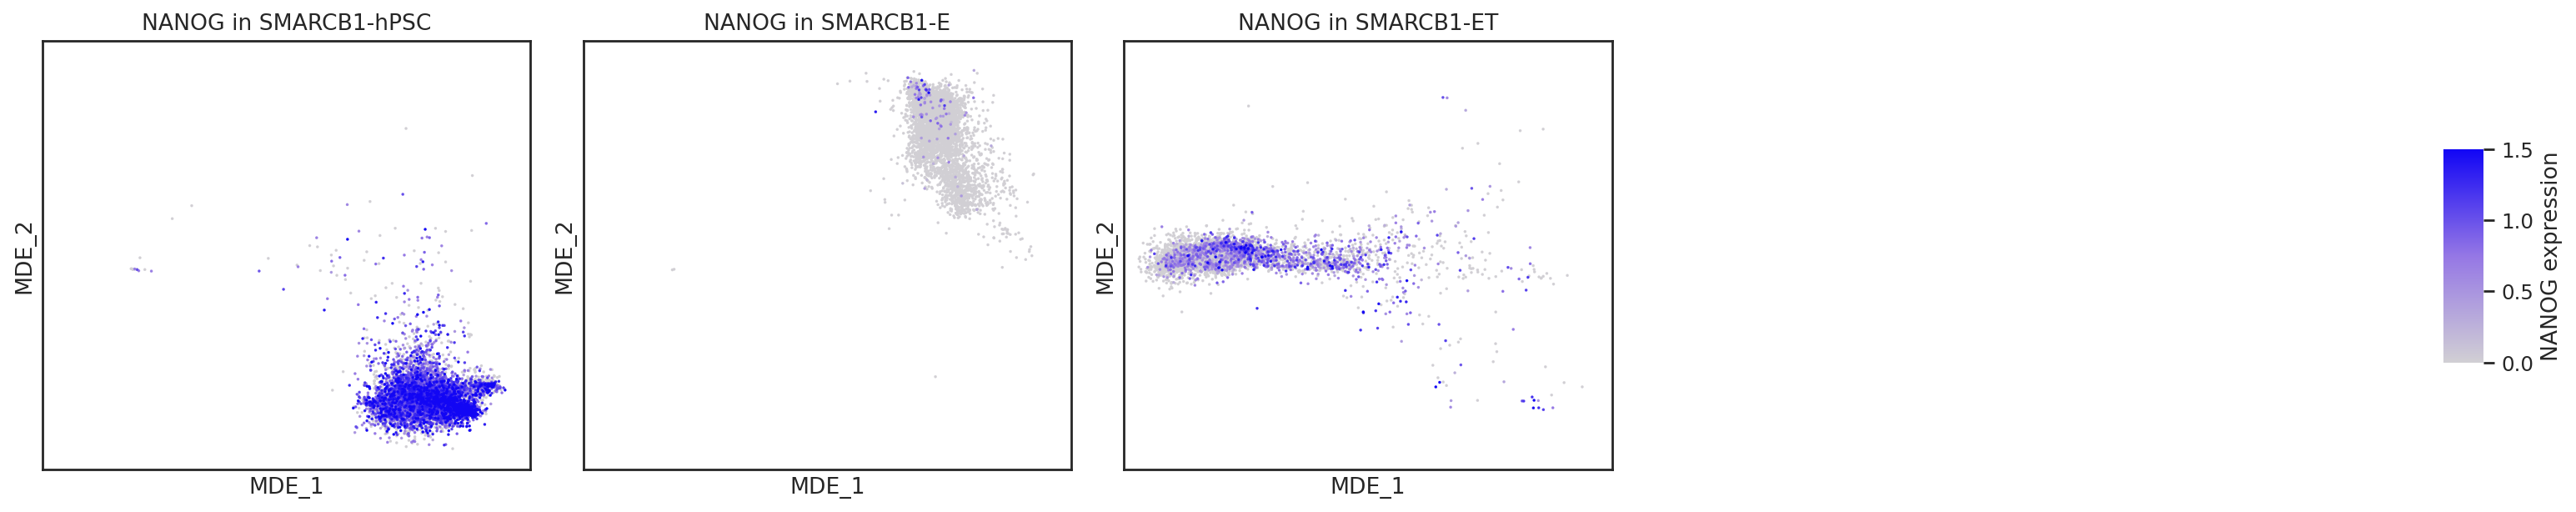

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors

# 设置参数
gene = 'NANOG'
sample_list = ['SMARCB1-hPSC', 'SMARCB1-E', 'SMARCB1-ET' ]
ncols = 4
nrows = (len(sample_list) + ncols - 1) // ncols

# 颜色参数
vmin, vmax = 0, 1.5
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)


import seaborn as sns, matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm, pandas as pd
mycmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#d1cfd4", "#9577e5", "#1206f5"])


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

sns.set_theme(style="white")

for i, sample_name in enumerate(sample_list):
    adata_sub = adata1[adata1.obs['sample'] == sample_name].copy()
    data1 = pd.DataFrame(adata_sub.obsm['X_mde'], columns=['MDE_1','MDE_2'])
    data1[gene] = adata_sub[:, gene].X.toarray().flatten()
    data1 = data1.sort_values(gene).copy()

    ax = axes[i]
    scatter = sns.scatterplot(
        data=data1,
        x='MDE_1', y='MDE_2',
        hue=gene,
        palette=mycmap,
        s=2, alpha=1.00,
        edgecolor=None,
        hue_norm=(vmin, vmax),
        legend=False,
        ax=ax
    )
    
    mappable = scatter.collections[0]
    mappable.set_cmap(mycmap)
    mappable.set_norm(norm)

    ax.set_title(f"{gene} in {sample_name}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim([-1.8, 1.0]); ax.set_ylim([-1.3, 1.2])

# 单独添加一个 colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.outline.set_visible(False)
cbar.set_label(f"{gene} expression")

# 删除多余子图
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.savefig("Figure.pool4-SMARCB1-samples.NANOG.MDEmap.pdf", dpi=300, bbox_inches='tight')
plt.show()
